Starting Enhanced Activity Analysis...

Analyzing The Fellowship of the Ring...


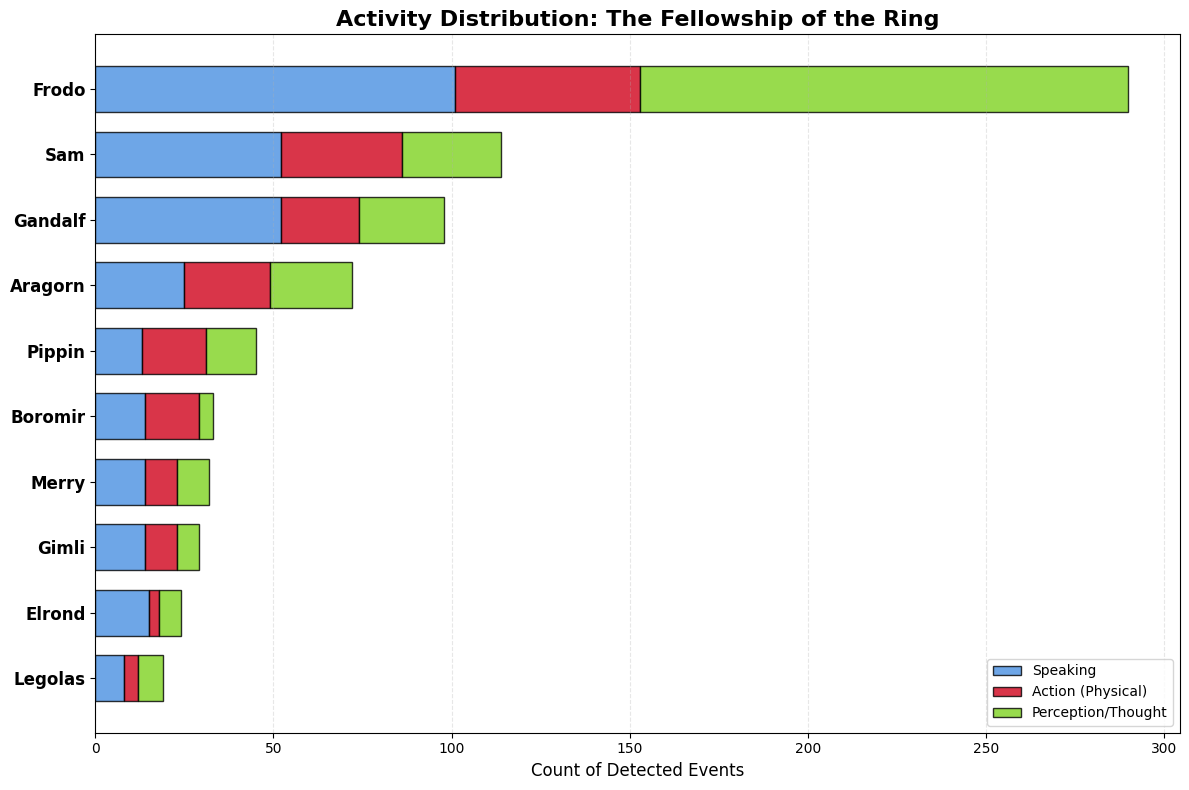

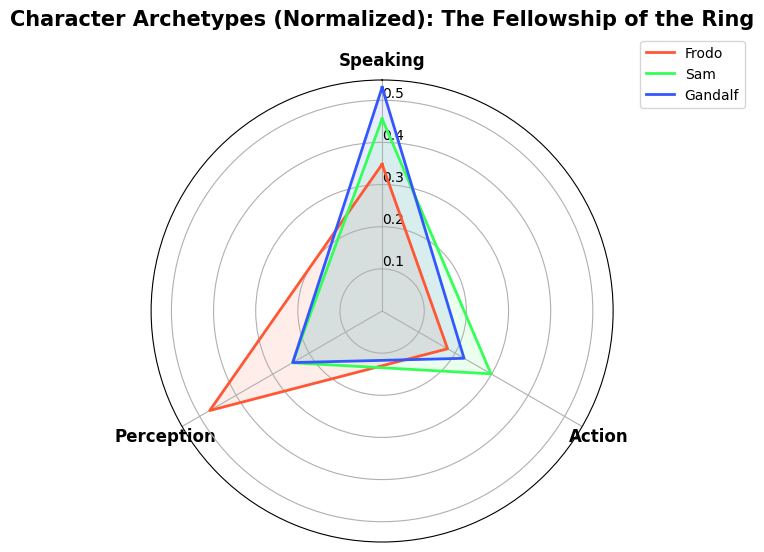


Analyzing The Two Towers...


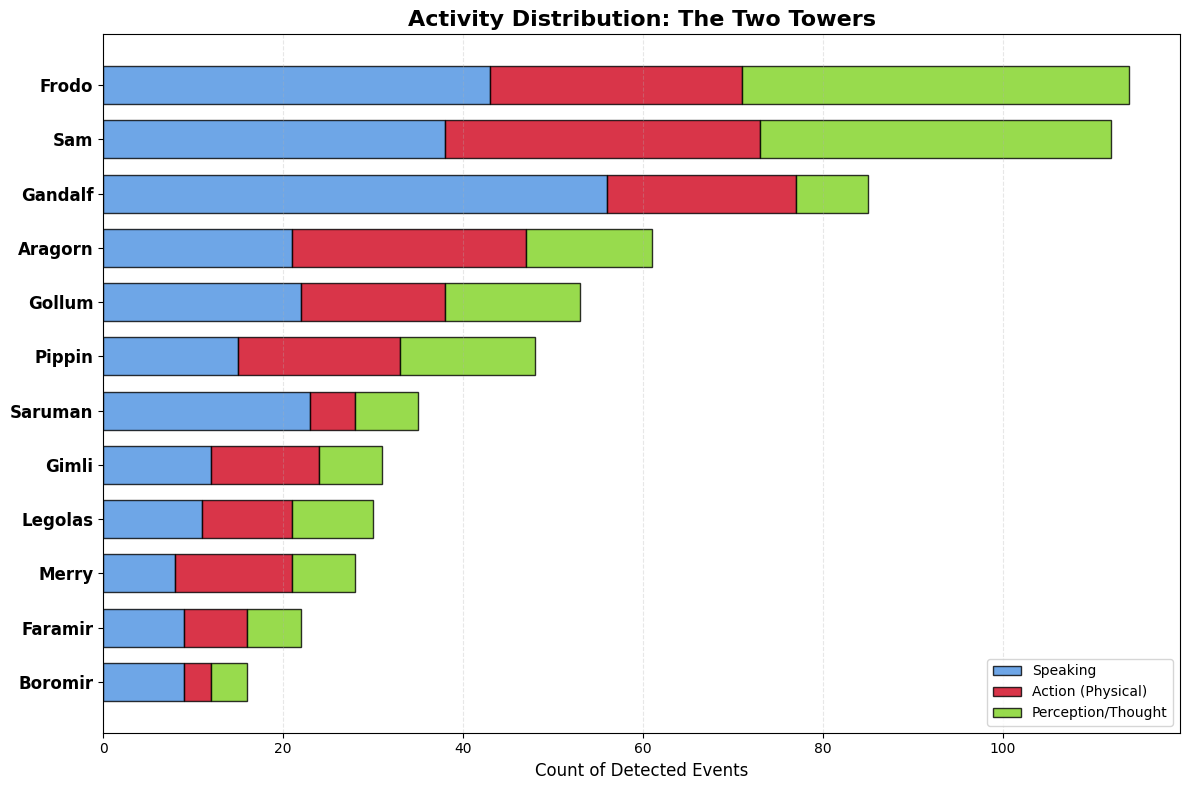

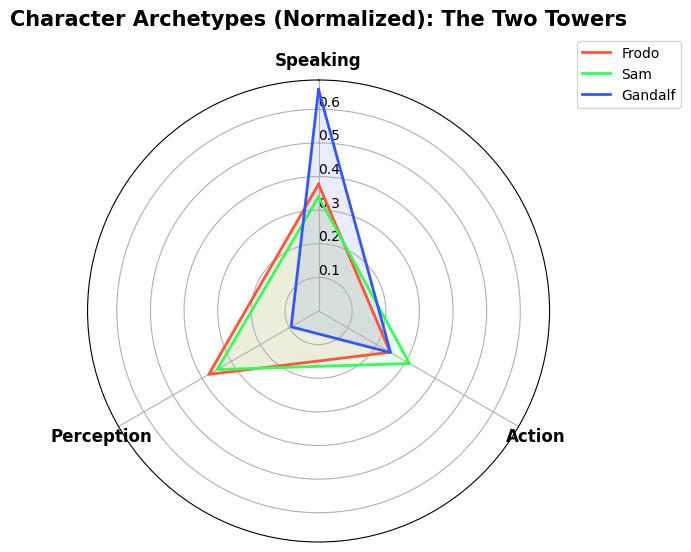


Analyzing The Return of the King...


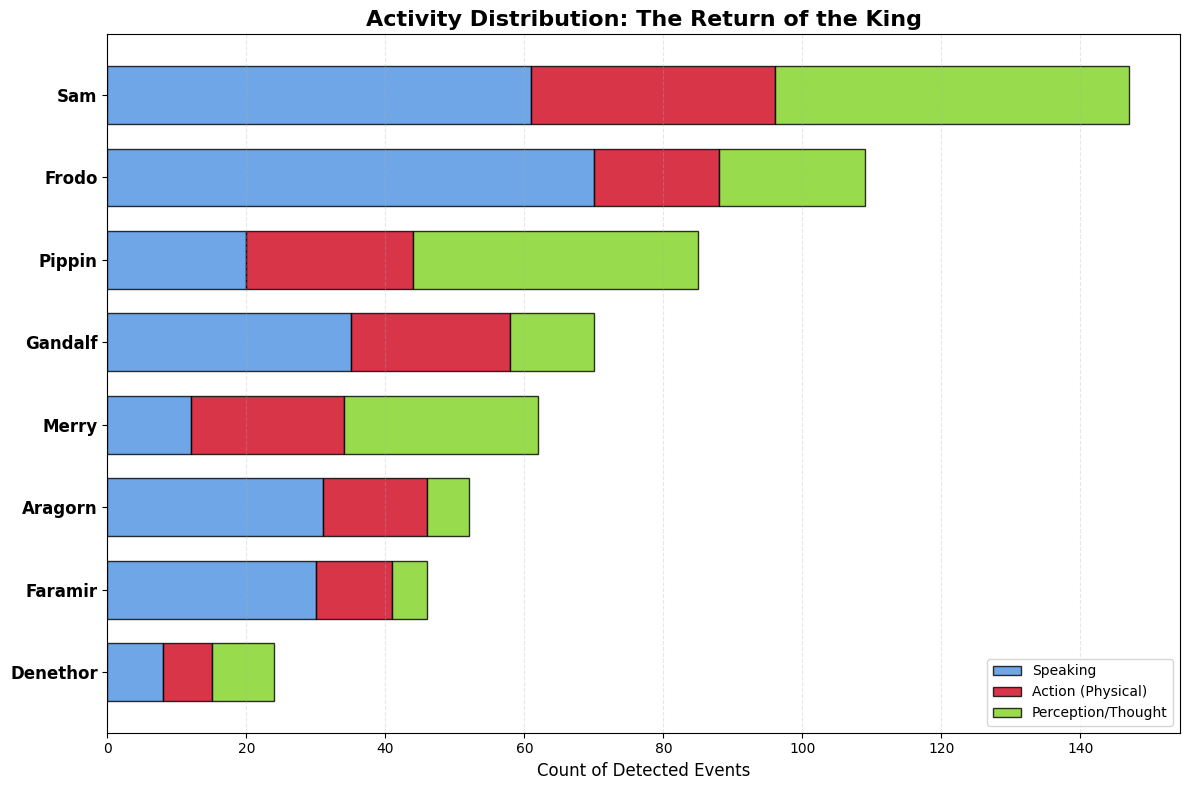

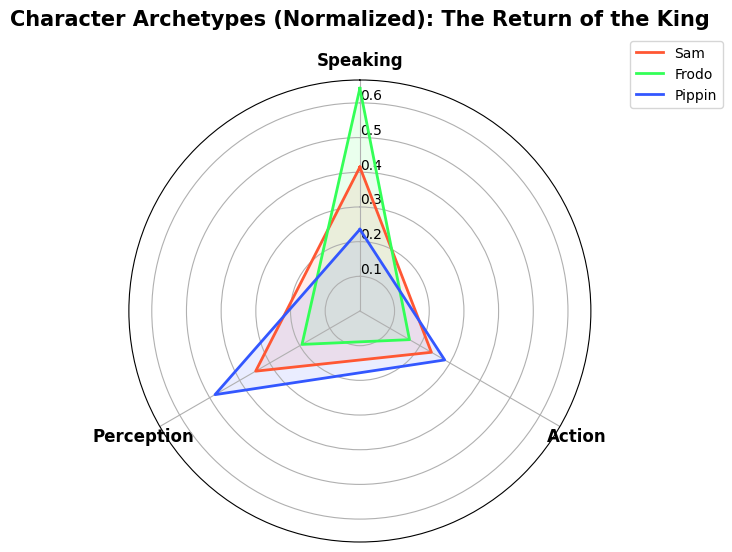

In [2]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# Character Mapping
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir", "greyhame"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took"],
    "Merry": ["merry", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord"],
    "Galadriel": ["galadriel"],
    "Elrond": ["elrond"],
    "Theoden": ["theoden"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Denethor": ["denethor"]
}

# Create alias lookup
ALIAS_MAP = {}
for main_name, aliases in CHARACTERS.items():
    for alias in aliases:
        ALIAS_MAP[alias] = main_name

# --- IMPROVED VERB DICTIONARIES ---
# Expanded lists for better coverage
VERB_CATEGORIES = {
    "Speaking": set([
        "said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
        "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
        "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
        "continued", "added", "explained", "agreed", "announced"
    ]),
    "Action (Physical)": set([
        "ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
        "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
        "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
        "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed"
    ]),
    "Perception/Thought": set([
        "saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
        "noticed", "listened", "wondered", "remembered", "feared", "hoped",
        "stared", "glanced", "gazed", "perceived", "understood", "believed", 
        "realized", "guessed"
    ])
}

# Words to ignore when scanning window (adverbs, fillers)
SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    """Loads and tokenizes text."""
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    # Strip headers
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: 
            start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: 
            end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=4):
    """
    Scans for Character + Verb patterns with improved skip-logic.
    """
    stats = defaultdict(lambda: defaultdict(int))
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            
            # Look at the next few words
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: 
                    continue # Skip adverbs to find the verb
                
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb:
                    break
                    
    return stats

# --- VISUALIZATION 1: Horizontal Stacked Bar ---
def plot_horizontal_activity(stats, title):
    """
    Horizontal Stacked Bar Chart for easier reading of names.
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars:
        print(f"Not enough data for {title}")
        return

    sorted_chars = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=False) # Ascending for horizontal
    top_chars = sorted_chars[-12:] # Top 12
    
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    data = {cat: [] for cat in categories}
    for char in top_chars:
        for cat in categories:
            data[cat].append(active_chars[char][cat])
            
    fig, ax = plt.subplots(figsize=(12, 8))
    
    bar_width = 0.7
    indices = np.arange(len(top_chars))
    lefts = np.zeros(len(top_chars))
    
    colors = ['#4a90e2', '#d0021b', '#7ed321'] # Blue, Red, Green
    
    for i, cat in enumerate(categories):
        values = np.array(data[cat])
        ax.barh(indices, values, left=lefts, label=cat, height=bar_width, 
               color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values

    ax.set_title(f"Activity Distribution: {title}", fontsize=16, fontweight='bold')
    ax.set_xlabel("Count of Detected Events", fontsize=12)
    ax.set_yticks(indices)
    ax.set_yticklabels(top_chars, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(axis='x', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# --- VISUALIZATION 2: Radar Charts (Spider Plots) ---
def plot_radar_profiles(stats, title):
    """
    Creates Radar Charts for the Top 3 most active characters.
    Shows the 'shape' of their behavior (e.g. Fighter vs Talker).
    """
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 15}
    if not active_chars: return

    # Pick top 3 active chars
    top_3 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:3]
    categories = ["Speaking", "Action", "Perception"] # Shortened labels
    
    # Setup Radar Plot
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] # Close loop
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    colors = ['#FF5733', '#33FF57', '#3357FF']
    
    for i, char in enumerate(top_3):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        # Normalize values to compare shape, not just volume
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] # Close loop
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=colors[i])
        ax.fill(angles, norm_values, color=colors[i], alpha=0.1)

    plt.title(f"Character Archetypes (Normalized): {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Activity Analysis...")

for title, path in books:
    print(f"\nAnalyzing {title}...")
    tokens = clean_and_tokenize(path)
    
    if tokens:
        stats = analyze_activity(tokens, ALIAS_MAP)
        # Plot 1: Volume & Breakdown
        plot_horizontal_activity(stats, title)
        # Plot 2: Archetype Shape
        plot_radar_profiles(stats, title)
    else:
        print("Error: No tokens found.")

Starting Enhanced Analysis (Female Characters)...

Analyzing The Fellowship of the Ring...

--- Contextual Analysis: The Fellowship of the Ring ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Galadriel       | 38         | 15         | Active participant.
Goldberry       | 31         | 14         | Active participant.
Luthien         | 23         | 5          | Active participant.
Elbereth        | 22         | 7          | Active participant.
Arwen           | 18         | 5          | Active participant.
Lobelia         | 13         | 3          | Active participant.
--------------------------------------------------------------------------------



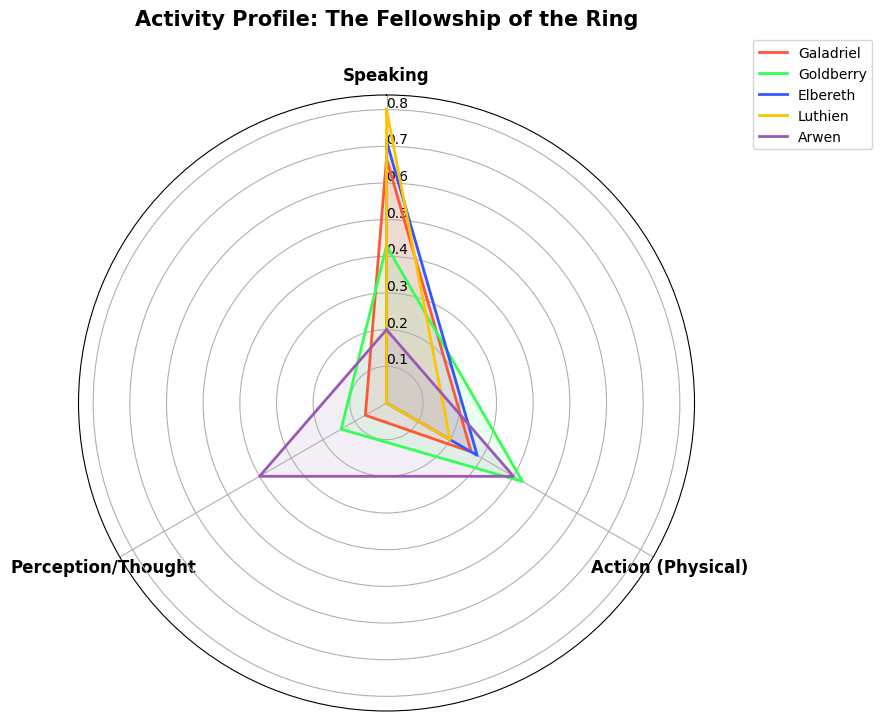


Analyzing The Two Towers...

--- Contextual Analysis: The Two Towers ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Shelob          | 33         | 5          | Active participant.
Galadriel       | 23         | 5          | Active participant.
Elbereth        | 4          | 0          | Deity/Vala. Invoked in prayer/song. Passive presence.
Arwen           | 2          | 0          | Appears in Aragorn's memories/dreams, not physical narrative.
--------------------------------------------------------------------------------



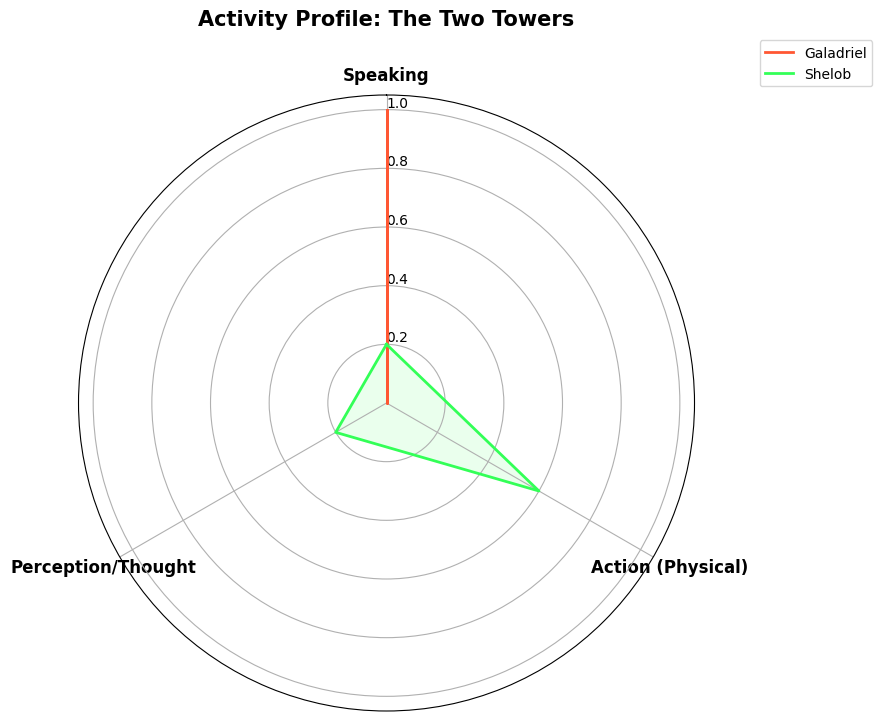


Analyzing The Return of the King...

--- Contextual Analysis: The Return of the King ---
Character       | Mentions   | Actions    | Context/Explanation
--------------------------------------------------------------------------------
Rosie           | 129        | 29         | Active participant.
Galadriel       | 22         | 8          | Active participant.
Eowyn           | 21         | 6          | Active participant.
Arwen           | 20         | 6          | Active participant.
Ioreth          | 14         | 3          | Active participant.
Elbereth        | 9          | 2          | Active participant.
Lobelia         | 2          | 1          | Active participant.
--------------------------------------------------------------------------------



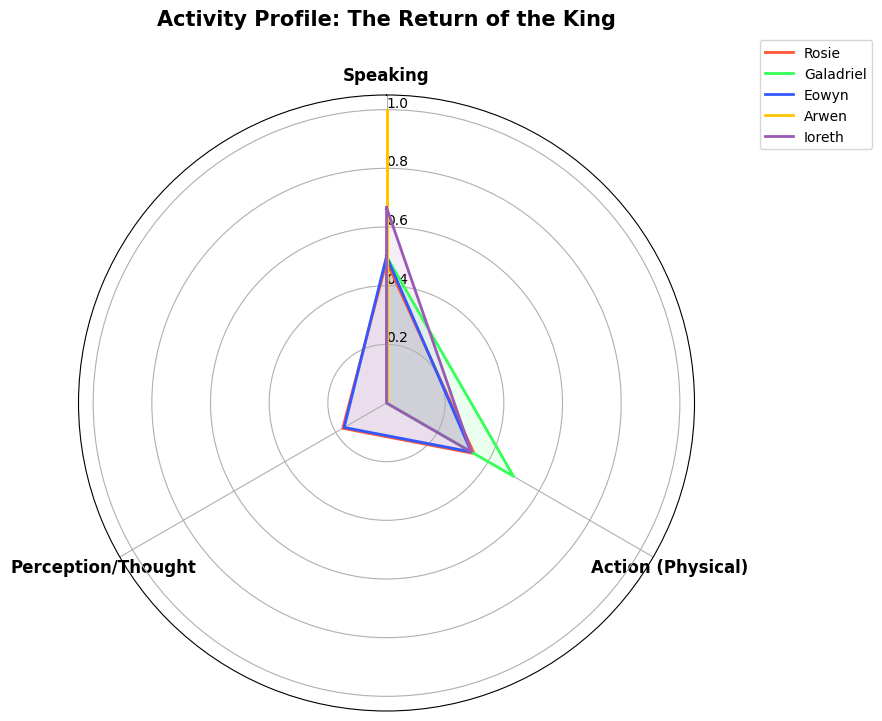

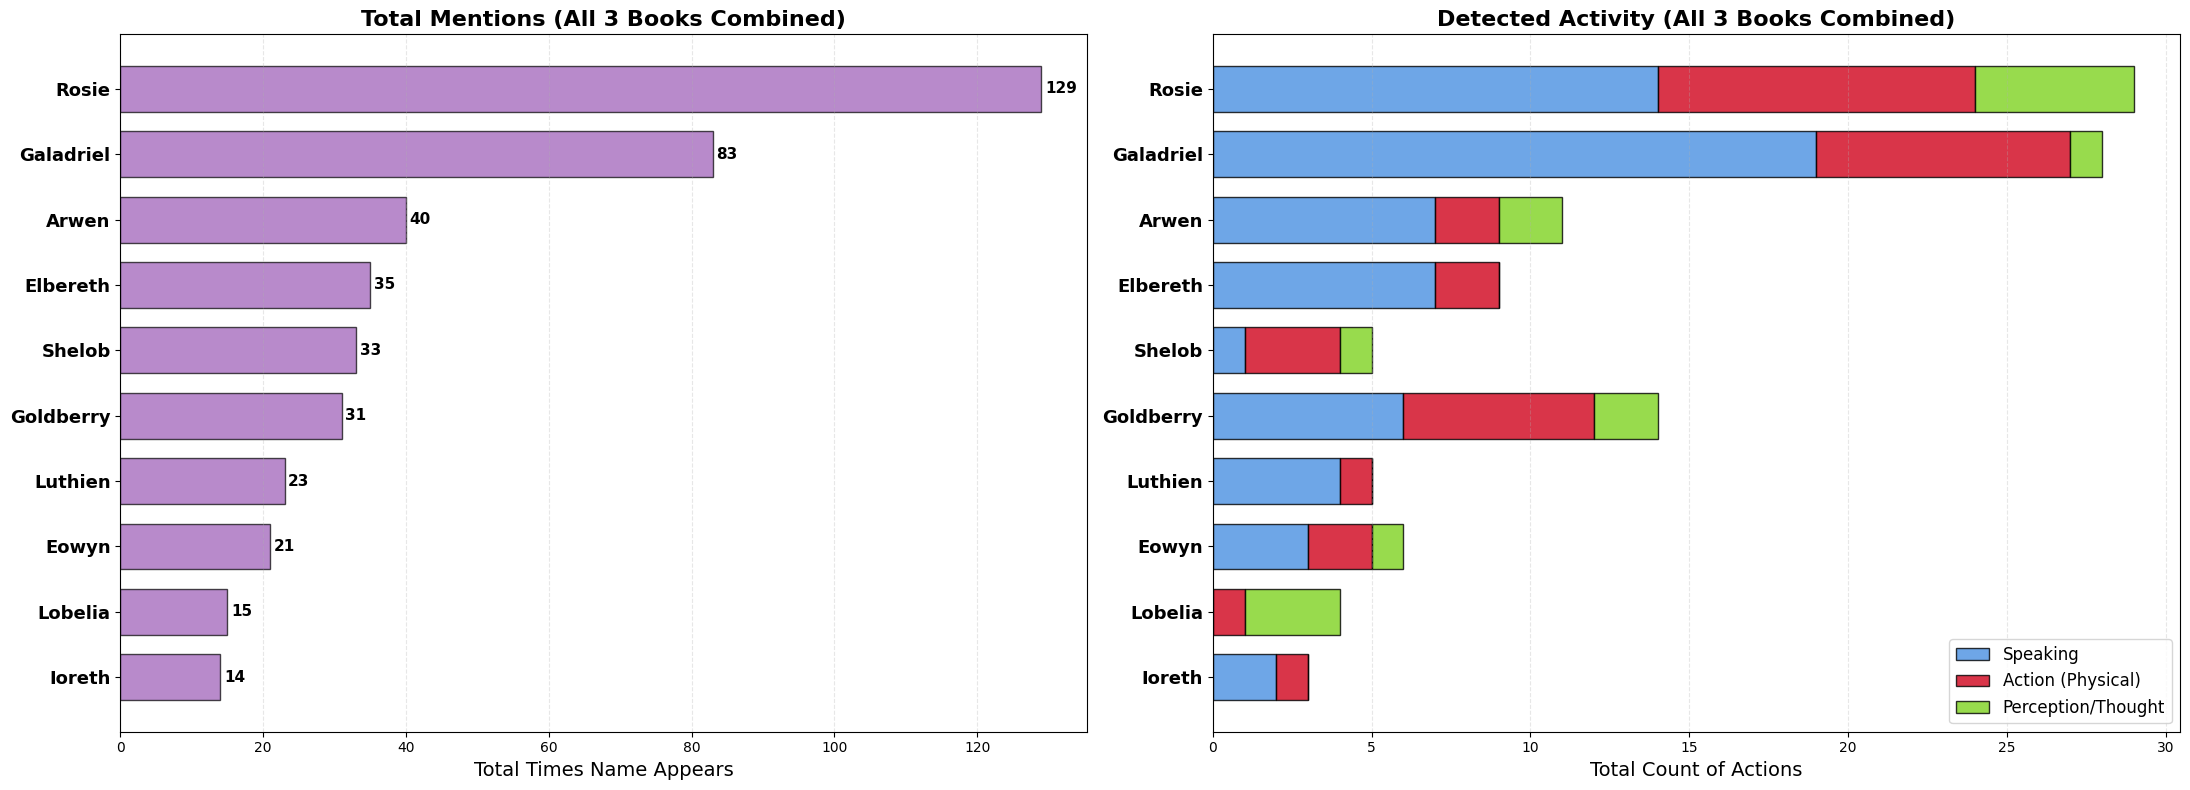

In [3]:
import matplotlib.pyplot as plt
import re
from pathlib import Path
from collections import defaultdict
import numpy as np
from math import pi

# --- CONFIG ---
CONFIG = {
    "book1_path": "../data/Fellowship.txt",
    "book2_path": "../data/TwoTowers.txt",
    "book3_path": "../data/TheKing.txt",
}

# --- MASTER CHARACTER MAPPING ---
FEMALE_CHARACTERS_COMPREHENSIVE = {
    # Major Active
    "Galadriel": ["galadriel", "lady of light", "lady of the wood", "sorceress of the golden wood", "lady of lorien", "white lady"],
    "Eowyn": ["eowyn", "damsel", "shieldmaiden", "dernhelm", "sister-daughter", "lady of rohan", "white lady of rohan"], 
    "Arwen": ["arwen", "undomiel", "evenstar", "daughter of elrond", "queen"], 
    "Shelob": ["shelob", "spider", "her ladyship"], 
    "Goldberry": ["goldberry", "river-daughter", "river-woman's daughter"], 
    
    # Minor / Supporting / Historical / Deities
    "Rosie": ["rosie", "cotton", "rose", "rosie-lass"], 
    "Ioreth": ["ioreth", "wise-woman", "old wife"], 
    "Lobelia": ["lobelia", "sackville-baggins"], 
    "Primula": ["primula"], 
    "Belladonna": ["belladonna"], 
    "Gilraen": ["gilraen"], 
    "Luthien": ["luthien", "tinuviel", "nightingale"], 
    "Elbereth": ["elbereth", "gilthoniel", "varda", "star-kindler"], 
}

# --- BOOK FILTERS ---
# (Used primarily for book-specific context, but we will aggregate for the main charts)
BOOK_FILTERS = {
    "The Fellowship of the Ring": ["Galadriel", "Goldberry", "Arwen", "Lobelia", "Luthien", "Elbereth", "Gilraen"],
    "The Two Towers": ["Eowyn", "Shelob", "Galadriel", "Arwen", "Elbereth", "Luthien"],
    "The Return of the King": ["Eowyn", "Arwen", "Rosie", "Ioreth", "Lobelia", "Galadriel", "Elbereth", "Luthien"],
}

# --- EXPANDED VERB DICTIONARIES ---
VERB_CATEGORIES = {
    "Speaking": set(["said", "asked", "replied", "answered", "cried", "shouted", "whispered", 
                     "spoke", "called", "told", "sang", "muttered", "screamed", "yelled",
                     "commanded", "demanded", "begged", "warned", "laughed", "sighed", 
                     "continued", "added", "explained", "agreed", "announced", "greeting", "wept"]),
    "Action (Physical)": set(["ran", "rode", "walked", "stood", "fought", "struck", "drew", "fell", 
                              "climbed", "leaped", "sprang", "marched", "rushed", "fled", "held", 
                              "lifted", "threw", "killed", "jumped", "turned", "stepped", "sat", 
                              "slept", "ate", "drank", "galloped", "charged", "swung", "cast", "bowed",
                              "went", "came", "gave", "took", "put", "set", "lay", "waited", "passed", "crawled", "stung", "bit"]),
    "Perception/Thought": set(["saw", "heard", "thought", "felt", "knew", "looked", "seemed", "watched", 
                               "noticed", "listened", "wondered", "remembered", "feared", "hoped",
                               "stared", "glanced", "gazed", "perceived", "understood", "believed", 
                               "realized", "guessed", "loved", "wished"])
}

SKIP_WORDS = set(["then", "suddenly", "quickly", "slowly", "just", "now", "not", "there", "away", "back", "again", "and", "but", "so", "very"])

# --- DATA LOADING ---
def clean_and_tokenize(filepath):
    path = Path(filepath)
    if not path.exists():
        print(f"Warning: {path} not found.")
        return []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()
    
    start_markers = ["*** START", "PROLOGUE", "Chapter 1", "BOOK I", "BOOK III", "BOOK V"]
    end_markers = ["*** END", "End of Project Gutenberg"]
    start_idx, end_idx = 0, len(text)
    
    for m in start_markers:
        idx = text.find(m)
        if idx != -1: start_idx = idx; break
    for m in end_markers:
        idx = text.find(m)
        if idx != -1: end_idx = idx; break
            
    clean_text = text[start_idx:end_idx].lower()
    return re.findall(r"[a-z]+(?:'[a-z]+)?", clean_text)

# --- ANALYSIS LOGIC ---
def analyze_activity(tokens, alias_map, window_after=6):
    activity_stats = defaultdict(lambda: defaultdict(int))
    mention_stats = defaultdict(int)
    
    for i, word in enumerate(tokens):
        if word in alias_map:
            char_name = alias_map[word]
            mention_stats[char_name] += 1 
            
            end_idx = min(len(tokens), i + 1 + window_after)
            next_words = tokens[i+1 : end_idx]
            
            found_verb = False
            for w in next_words:
                if w in SKIP_WORDS: continue
                for category, verbs in VERB_CATEGORIES.items():
                    if w in verbs:
                        activity_stats[char_name][category] += 1
                        found_verb = True
                        break 
                if found_verb: break
                    
    return activity_stats, mention_stats

# --- EXPLANATION GENERATOR ---
def explain_passive_characters(activity_stats, mention_stats, title):
    print(f"\n--- Contextual Analysis: {title} ---")
    print(f"{'Character':<15} | {'Mentions':<10} | {'Actions':<10} | {'Context/Explanation'}")
    print("-" * 80)
    
    sorted_chars = sorted(mention_stats.keys(), key=lambda x: mention_stats[x], reverse=True)
    
    for char in sorted_chars:
        mentions = mention_stats[char]
        if mentions == 0: continue
        
        actions = sum(activity_stats[char].values())
        explanation = "Active participant."
        
        if actions == 0:
            if char in ["Elbereth", "Varda"]:
                explanation = "Deity/Vala. Invoked in prayer/song. Passive presence."
            elif char in ["Luthien", "Tinuviel"]:
                explanation = "Historical figure. Appears in songs/tales."
            elif char == "Gilraen":
                explanation = "Historical figure (Aragorn's mother). Mentioned in memory."
            elif char == "Galadriel" and "Two Towers" in title:
                explanation = "Mentioned by Fellowship/Saruman, not physically present."
            elif char == "Arwen" and "Two Towers" in title:
                explanation = "Appears in Aragorn's memories/dreams, not physical narrative."
            else:
                explanation = "Mentioned by others but performs no detected actions."
        
        print(f"{char:<15} | {mentions:<10} | {actions:<10} | {explanation}")
    print("-" * 80 + "\n")

# --- COMBINED PLOT GENERATION ---
def plot_combined_analysis(all_mentions, all_activity):
    """
    Plots Total Mentions and Activity aggregated across all three books.
    """
    # 1. Aggregate data across books
    total_mentions = defaultdict(int)
    total_activity = defaultdict(lambda: defaultdict(int))
    
    for book_mentions in all_mentions:
        for char, count in book_mentions.items():
            total_mentions[char] += count
            
    for book_activity in all_activity:
        for char, cats in book_activity.items():
            for cat, count in cats.items():
                total_activity[char][cat] += count

    # Filter characters with > 0 mentions
    active_chars = [c for c in total_mentions if total_mentions[c] > 0]
    if not active_chars:
        print("No character data found to plot.")
        return

    # Sort characters by TOTAL MENTIONS
    sorted_chars = sorted(active_chars, key=lambda x: total_mentions[x], reverse=False)

    # --- PLOT SETUP ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, max(8, len(sorted_chars) * 0.8)))
    indices = np.arange(len(sorted_chars))
    bar_width = 0.7

    # --- CHART 1: TOTAL MENTIONS (Aggregated) ---
    mention_values = [total_mentions[c] for c in sorted_chars]
    ax1.barh(indices, mention_values, color='#9b59b6', edgecolor='black', height=bar_width, alpha=0.7)
    ax1.set_title("Total Mentions (All 3 Books Combined)", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Total Times Name Appears", fontsize=14)
    ax1.set_yticks(indices)
    ax1.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax1.grid(axis='x', linestyle='--', alpha=0.3)
    
    for i, v in enumerate(mention_values):
        ax1.text(v + 0.5, i, str(v), va='center', fontsize=11, fontweight='bold')

    # --- CHART 2: DETECTED ACTIVITY (Aggregated) ---
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    colors = ['#4a90e2', '#d0021b', '#7ed321']
    lefts = np.zeros(len(sorted_chars))
    
    for i, cat in enumerate(categories):
        values = np.array([total_activity[c][cat] for c in sorted_chars])
        ax2.barh(indices, values, left=lefts, label=cat, height=bar_width, color=colors[i], edgecolor='black', alpha=0.8)
        lefts += values
        
    ax2.set_title("Detected Activity (All 3 Books Combined)", fontsize=16, fontweight='bold')
    ax2.set_xlabel("Total Count of Actions", fontsize=14)
    ax2.set_yticks(indices)
    ax2.set_yticklabels(sorted_chars, fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=12)
    ax2.grid(axis='x', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

# --- RADAR CHART FUNCTION (Per Book) ---
def plot_book_radar_profiles(stats, title):
    active_chars = {k: v for k, v in stats.items() if sum(v.values()) > 0} 
    if not active_chars: return

    # Top 5 most active in THIS book
    top_5 = sorted(active_chars.keys(), key=lambda x: sum(active_chars[x].values()), reverse=True)[:5]
    categories = ["Speaking", "Action (Physical)", "Perception/Thought"]
    
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1] 
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    plt.xticks(angles[:-1], categories, size=12, fontweight='bold')
    ax.set_rlabel_position(0)
    
    colors = ['#FF5733', '#33FF57', '#3357FF', '#FFC300', '#9B59B6']
    
    for i, char in enumerate(top_5):
        values = [
            active_chars[char]["Speaking"],
            active_chars[char]["Action (Physical)"],
            active_chars[char]["Perception/Thought"]
        ]
        
        total = sum(values) if sum(values) > 0 else 1
        norm_values = [v/total for v in values]
        norm_values += norm_values[:1] 
        
        color = colors[i % len(colors)]
        
        ax.plot(angles, norm_values, linewidth=2, linestyle='solid', label=char, color=color)
        ax.fill(angles, norm_values, color=color, alpha=0.1)

    plt.title(f"Activity Profile: {title}", size=15, fontweight='bold', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.show()

# --- MAIN EXECUTION ---
books = [
    ("The Fellowship of the Ring", CONFIG["book1_path"]),
    ("The Two Towers", CONFIG["book2_path"]),
    ("The Return of the King", CONFIG["book3_path"])
]

print("Starting Enhanced Analysis (Female Characters)...")

# Data collectors for the final combined chart
all_books_mentions = []
all_books_activity = []

for title, path in books:
    print(f"\nAnalyzing {title}...")
    relevant_names = BOOK_FILTERS.get(title, [])
    
    # Create Book-Specific Alias Map
    book_alias_map = {}
    for name in relevant_names:
        for alias in FEMALE_CHARACTERS_COMPREHENSIVE.get(name, []):
            book_alias_map[alias] = name
            
    tokens = clean_and_tokenize(path)
    
    if tokens:
        act_stats, men_stats = analyze_activity(tokens, book_alias_map, window_after=6)
        
        # Store for combined analysis later
        all_books_mentions.append(men_stats)
        all_books_activity.append(act_stats)
        
        # 1. Print Textual Explanation for Passive Characters (Per Book)
        explain_passive_characters(act_stats, men_stats, title)
        
        # 2. Generate Radar Chart for THIS book (as requested to keep per book)
        plot_book_radar_profiles(act_stats, title)

    else:
        print(f"Error: No tokens found for {title}.")

# 3. Generate ONE Combined Mentions/Activity Chart for ALL books
if all_books_mentions and all_books_activity:
    plot_combined_analysis(all_books_mentions, all_books_activity)